In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
path = '../input/camvid-master/'

In [3]:
images_path = path + '701_StillsRaw_full/'
labels_path = path + 'LabeledApproved_full/'

In [4]:
images = glob.glob(images_path + '*.png')
print (images[:3])

labels = [labels_path + os.path.basename(i)[:-4] + '_L.png' for i in images]
print (labels[:3])

['../input/camvid-master/701_StillsRaw_full/Seq05VD_f00000.png', '../input/camvid-master/701_StillsRaw_full/0001TP_009000.png', '../input/camvid-master/701_StillsRaw_full/0016E5_07967.png']
['../input/camvid-master/LabeledApproved_full/Seq05VD_f00000_L.png', '../input/camvid-master/LabeledApproved_full/0001TP_009000_L.png', '../input/camvid-master/LabeledApproved_full/0016E5_07967_L.png']


In [5]:
image_size = (480,360)

In [6]:
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

In [7]:
imgs = np.stack([open_image(i) for i in images])
imgs.shape

(701, 360, 480, 3)

In [8]:
lbs = np.stack([open_image(l) for l in labels])
lbs.shape

(701, 360, 480, 3)

In [9]:
imgs = imgs/255.

In [10]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.39996644266360742, 0.30179491142290965)

In [11]:
imgs-=imgs.mean()
imgs/=imgs.std()

In [35]:
# save_array('imgs.bc', imgs)
# save_array('lbs.bc', labels)

In [12]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [13]:
bi = BatchIndices(10,3, True)
[next(bi) for o in range(5)]

[array([2, 6, 7]),
 array([8, 4, 1]),
 array([9, 5, 3]),
 array([0]),
 array([5, 3, 8])]

In [14]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [15]:
sg = segm_generator(imgs, lbs, 4, train=False)
b_img, b_label = next(sg)

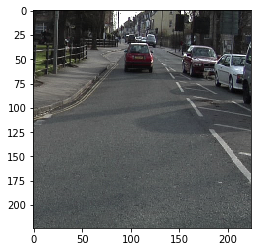

In [16]:
plt.imshow(b_img[0]*0.3+0.4);

In [17]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [18]:
label_codes, label_names = zip(*[parse_code(l) for l in open(path+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

len(label_names)

32

In [19]:
label_codes, label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',
  'VegetationMisc',
  'Void'

In [20]:
code2id = {v:k for k,v in enumerate(label_codes)}

id2code = {k:v for k,v in enumerate(label_codes)}

In [21]:
code2id

{(0, 0, 0): 30,
 (0, 0, 64): 23,
 (0, 0, 192): 19,
 (0, 64, 64): 24,
 (0, 128, 64): 3,
 (0, 128, 192): 2,
 (64, 0, 64): 28,
 (64, 0, 128): 5,
 (64, 0, 192): 6,
 (64, 64, 0): 16,
 (64, 64, 128): 9,
 (64, 128, 64): 0,
 (64, 128, 192): 22,
 (64, 192, 0): 31,
 (64, 192, 128): 15,
 (128, 0, 0): 4,
 (128, 0, 192): 10,
 (128, 64, 64): 14,
 (128, 64, 128): 17,
 (128, 128, 0): 26,
 (128, 128, 64): 12,
 (128, 128, 128): 21,
 (128, 128, 192): 18,
 (192, 0, 64): 11,
 (192, 0, 128): 1,
 (192, 0, 192): 13,
 (192, 64, 128): 25,
 (192, 128, 64): 7,
 (192, 128, 128): 20,
 (192, 128, 192): 27,
 (192, 192, 0): 29,
 (192, 192, 128): 8}

In [22]:
failed_code = len(label_codes)+1
failed_code

33

In [23]:
n,r,c,ch = imgs.shape
n, r, c, ch

(701, 360, 480, 3)

In [24]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(lbs[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [25]:
from concurrent.futures import ProcessPoolExecutor

In [26]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

In [27]:
labels_int = conv_all_labels()

In [34]:
# save_array('labels_int.bc', labels_int)

In [28]:
np.count_nonzero(labels_int==failed_code)

44

In [29]:
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)

print (len(l))

1


In [30]:
l

[462]

In [31]:
labels_int = np.delete(labels_int, l, axis=0)
len(labels_int)

700

In [32]:
labels_int.shape

(700, 360, 480)

In [33]:
np.count_nonzero(labels_int==failed_code)

0

In [34]:
imgs = np.delete(imgs, l, axis=0)
len(imgs)

700

In [35]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

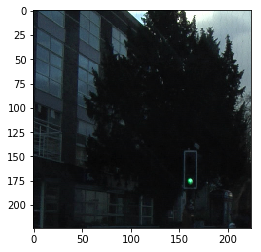

In [36]:
sg = segm_generator(imgs, lbs, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4)

In [37]:
def dict_color_label(x):
    l = [code2id[tuple(i)] for i in x]
    l = np.array(l)
    return l

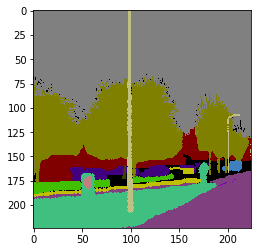

In [38]:
temp = dict_color_label(b_label[0])
plt.imshow(color_label(np.resize(temp, (224,224))))

## Creating Test Set

In [39]:
train_set = imgs[:468]
train_labels = labels_int[:468]

test_set = imgs[468:]
test_labels = labels_int[468:]

In [40]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(468, 232, 468, 232)

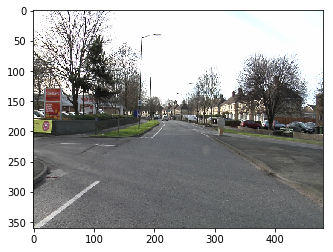

In [41]:
plt.imshow(train_set[462]*0.3+0.4)

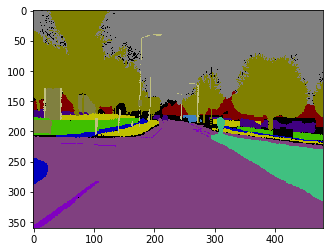

In [42]:
plt.imshow(color_label(train_labels[462]))

In [43]:
train_labels[0].shape

(360, 480)

In [42]:
train_generator = segm_generator(train_set, train_labels, 3, train=True)
test_generator = segm_generator(test_set, test_labels, 3, train=False)

In [70]:
i,la = next(train_generator)

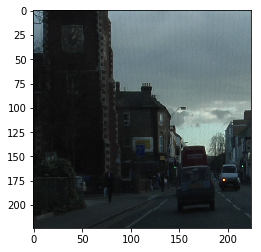

In [71]:
plt.imshow(i[0]*0.3+0.4)

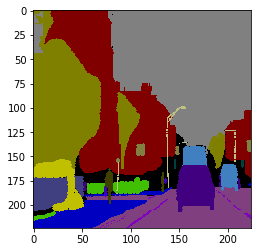

In [72]:
# t = dict_color_label(la[0])
plt.imshow(color_label(np.resize(la[0], (224,224))))

In [73]:
la[0].shape

(50176, 1)

In [43]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [44]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [45]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [46]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [47]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [48]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [49]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [50]:
def reverse(a): return list(reversed(a))

In [51]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

In [52]:
input_shape = (224,224,3)
img_input = Input(shape=input_shape)
x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [53]:
model = Model(img_input, x)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

I have trained this model only for 2 epochs since I didn't have any more GPU computation time left. But you can train it for 500 epochs or so to get state of the art results. Do some finetuning(learning rate annealing also.)

In [54]:
model.fit_generator(train_generator, len(train_set), 2, verbose=2,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/2
227s - loss: 2.4692 - acc: 0.4642 - val_loss: 2.3253 - val_acc: 0.5265
Epoch 2/2
213s - loss: 1.8467 - acc: 0.5211 - val_loss: 2.3351 - val_acc: 0.5049


In [58]:
model.save_weights('tiramisu_2_iterations.h5')

In [55]:
predictions = model.predict_generator(test_generator, len(test_set))

In [56]:
predictions = np.argmax(predictions, axis=-1)

In [57]:
predictions[0].shape

(50176,)

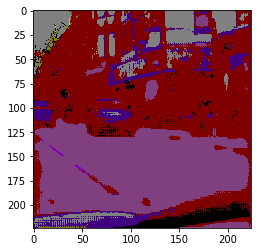

In [58]:
plt.imshow(color_label(np.resize(predictions[6], (224,224))))

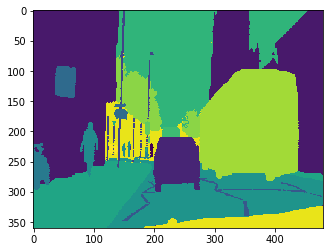

In [63]:
plt.imshow(test_labels[3])

In [103]:
j, t_la = next(test_generator)

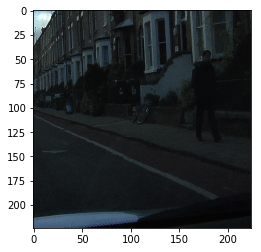

In [104]:
plt.imshow(j[0]*0.3+0.4)

In [81]:
try_image = np.array(Image.open('Seq05VD_f05100.png').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=mean
try_image/=std
try_image.shape

(224, 224, 3)

In [82]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)

In [83]:
try_preds = np.argmax(try_preds, axis=-1)
try_preds.shape

(1, 50176)

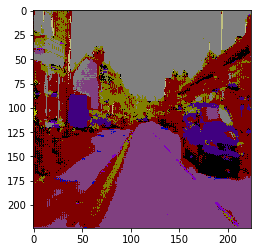

In [84]:
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))

In [90]:
try_img = np.array(Image.open('Seq05VD_f05100.png').resize(image_size, Image.NEAREST))
try_img = try_img/255.
try_img-=mean
try_img/=std

In [91]:
try_label = np.array(Image.open('Seq05VD_f05100_L.png').resize(image_size, Image.NEAREST))

In [92]:
try_gen = segm_generator(np.expand_dims(try_img, 0), np.expand_dims(try_img, 0), 1, train=False)

In [93]:
prd = model.predict_generator(try_gen, 1)

In [94]:
prd = np.argmax(prd, axis=-1)

In [95]:
prd.shape

(1, 50176)

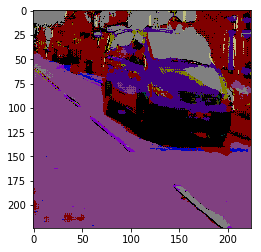

In [96]:
plt.imshow(color_label(np.resize(prd[0], (224,224))))